In [1]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, HypergraphConv

from dataHandler import ParticleDataset
from manifold import PoincareManifold
poincare = PoincareManifold()

import numpy as np
from time import time
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,ConnectionPatch
plt.style.use('dark_background')

In [2]:
def distance_matrix(nodes):
    #nodes=nodes
    _x = (nodes[:,0][...,None] - nodes[:,0])**2
    _y = (nodes[:,1][...,None] - nodes[:,1])**2
    matrix = torch.sqrt(_x + _y + 1e-8)
    return matrix

In [2]:
dataset = ParticleDataset('data/hz_test.hdf5','signal')
#data = dataset.__getitem__(0)
data_batches = DataLoader(dataset,batch_size=4,shuffle=False)

In [13]:
class gnn(torch.nn.Module):
    def __init__(self,_in,_h1,_h2,_out):
        super().__init__()
        self.conv1 = HypergraphConv(_in,_h1)
        self.conv2 = HypergraphConv(_h1,_h2)
        self.conv3 = HypergraphConv(_h2,_out)
        
    def forward(self,data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x,p=0.2)
        x = self.conv2(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x,p=0.2)
        x = self.conv3(x, edge_index)
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(4,64,2).to(device)
model.double()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [29]:
model.train()
for epoch in range(1):
    loss = []
    t = time()
    for data in data_batches:
        optimizer.zero_grad()
        out = model(data)
        loss_temp = 0
        for graph_idx in torch.unique(data.batch):
            graph_mask = data.batch == graph_idx
            _x = out[graph_mask]
            _y = data.y[graph_mask]
            
            _input = distance_matrix(_x)
            _target = distance_matrix(_y)
        
            loss_temp += F.mse_loss(_input,_target)
            
        loss.append(loss_temp)
        
        loss_temp.backward()
        optimizer.step()
        
    loss = torch.tensor(loss)
    print(f'epoch:{epoch}, mean loss:{torch.mean(loss.clone().detach())}, \
          time {round(time()-t,2)}')

epoch:0, mean loss:1.3309135676729338,           time 28.84


In [11]:
torch.save(model,'model_scripted.pt')

# Example 

In [40]:
dataset = ParticleDataset('data/hz_test.hdf5','signal')
#data = dataset.__getitem__(0)

loss is: 0.8203580277603973


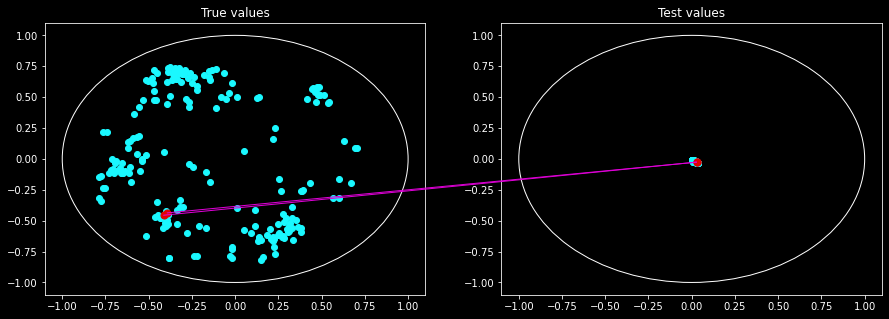

In [20]:
#model = torch.load('model_scripted.pt',map_location=torch.device('cpu'))
#model.eval()
data = dataset.__getitem__(0)
#out = model(data)
out = hgnn.hgnn(data)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()
ax[0].scatter(data.y[:,0],data.y[:,1],alpha=1,color='#1AF8FF')
ax[0].set_title('True values')

test = out.detach().clone()
ax[1].scatter(test[:,0],test[:,1],alpha=1,color='#1AF8FF')
ax[1].set_title('Test values')

disk = Circle((0,0),1,color='white',fill=False)
disk2 = Circle((0,0),1,color='white',fill=False)

ax[0].add_patch(disk)
ax[1].add_patch(disk2)

idxs = [0,1]
for idx00 in idxs:
    xy_left = data.y[idx00]
    xy_right = test[idx00]

    ax[0].scatter(xy_left[0],xy_left[1],alpha=1,color='#DF0101',s = 50)
    ax[1].scatter(xy_right[0],xy_right[1],s=50,c='#DF0101') #change color
    con = ConnectionPatch(xyA=xy_left, coordsA=ax[0].transData,xyB=xy_right, coordsB=ax[1].transData,color='#DF01D7')
    fig.add_artist(con)

length = len(out)
_input = distance_matrix(out)
_input = _input[torch.triu(torch.ones(length,length),diagonal=1) == 1]
_target = distance_matrix(data.y)
_target = _target[torch.triu(torch.ones(length,length),diagonal=1) == 1]
loss = F.mse_loss(_input,_target)
print(f'loss is: {loss}')    
plt.show()

## pytorch_lightning

In [4]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar
import torch as th
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from dataHandler import ParticleDataset
#from graphNN import GNN

In [5]:
train = ParticleDataset('data/hz_train.hdf5','signal')
train = DataLoader(train, batch_size=4, shuffle=True,num_workers=128)

test = ParticleDataset('data/hz_test.hdf5','signal')
test = DataLoader(test, batch_size=4,num_workers=128)

In [6]:
def distance_matrix(nodes):
    _a = (nodes[:,0][...,None] - nodes[:,0]) ** 2.
    _b = (nodes[:,1][...,None] - nodes[:,1]) ** 2.
    matrix = th.sqrt( _a + _b + 1e-8)
    return matrix

In [16]:
class LitHGNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.hgnn = gnn(4,64,64,2)
        self.hgnn.double()
        
    def training_step(self,batch,batch_idx):
        output = self.hgnn(batch)
        
        '''
        loss = 0
        for graph_idx in th.unique(batch.batch):
            graph_mask = batch.batch == graph_idx
            _x = output[graph_mask]
            _y = batch.y[graph_mask]

            _input = distance_matrix(_x)
            _target = distance_matrix(_y)

            loss += F.mse_loss(_input,_target)

        loss /= batch.num_graphs
        '''
        loss = F.mse_loss(output,batch.y)
        self.log('training loss',loss)
        return loss
    
    def test_step(self,batch,batch_idx):
        output = self.hgnn(batch)
        
        '''
        loss = 0
        for graph_idx in th.unique(batch.batch):
            graph_mask = batch.batch == graph_idx
            _x = output[graph_mask]
            _y = batch.y[graph_mask]

            _input = distance_matrix(_x)
            _target = distance_matrix(_y)

            loss += F.mse_loss(_input,_target)
        '''
        loss = F.mse_loss(output,batch.y)   
        self.log('test loss',loss)
        
    def configure_optimizers(self):
        optimizer = th.optim.Adam(self.parameters(),lr=1e-2)
        return optimizer

In [17]:
class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.set_description('running training ...')
        return bar

In [18]:
hgnn = LitHGNN()
bar = LitProgressBar()

trainer = pl.Trainer(max_epochs=2,callbacks=[bar])
trainer.fit(hgnn,train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type | Params
------------------------------
0 | hgnn | gnn  | 4.6 K 
------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [19]:
trainer.test(model=hgnn,test_dataloaders=test)

/scratch/gc2c20/miniconda3/envs/pyg/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(


Testing: 0it [00:00, ?it/s]

AttributeError: 'Tensor' object has no attribute 'x'

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Restoring states from the checkpoint path at /mainfs/home/gc2c20/myproject/hyperTree/lr_find_temp_model_91638849-b1c0-49db-a811-6780087a0e53.ckpt


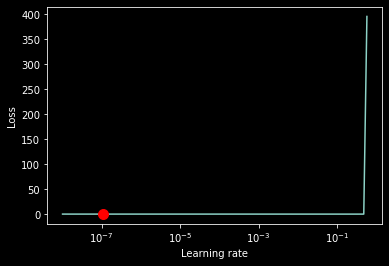

In [24]:
hgnn = LitHGNN()
trainer = pl.Trainer()

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(hgnn,train)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()